In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bird-vocalization-classifier/tensorflow2/bird-vocalization-classifier/2/saved_model.pb
/kaggle/input/bird-vocalization-classifier/tensorflow2/bird-vocalization-classifier/2/assets/genus.csv
/kaggle/input/bird-vocalization-classifier/tensorflow2/bird-vocalization-classifier/2/assets/family.csv
/kaggle/input/bird-vocalization-classifier/tensorflow2/bird-vocalization-classifier/2/assets/order.csv
/kaggle/input/bird-vocalization-classifier/tensorflow2/bird-vocalization-classifier/2/assets/label.csv
/kaggle/input/bird-vocalization-classifier/tensorflow2/bird-vocalization-classifier/2/variables/variables.index
/kaggle/input/bird-vocalization-classifier/tensorflow2/bird-vocalization-classifier/2/variables/variables.data-00000-of-00001
/kaggle/input/birdclef-2023/sample_submission.csv
/kaggle/input/birdclef-2023/eBird_Taxonomy_v2021.csv
/kaggle/input/birdclef-2023/train_metadata.csv
/kaggle/input/birdclef-2023/train_audio/yetgre1/XC247367.ogg
/kaggle/input/birdclef-2023/train_aud

In [2]:
## Importing the Libraries
import librosa
import matplotlib.pyplot as plt
import librosa.display
import IPython.display as ipd
import pandas as pd
import numpy as np
import seaborn as sns
import csv
import glob
import os

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
!pip install tensorflow_hub
!pip install tensorflow_io

In [4]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio

In [5]:
## Creating a file name to check an example of one of the audio 
filename="/kaggle/input/birdclef-2023/train_audio/whihel1/XC202623.ogg"
filename1="/kaggle/input/birdclef-2023/train_audio/thrnig1/XC118260.ogg"

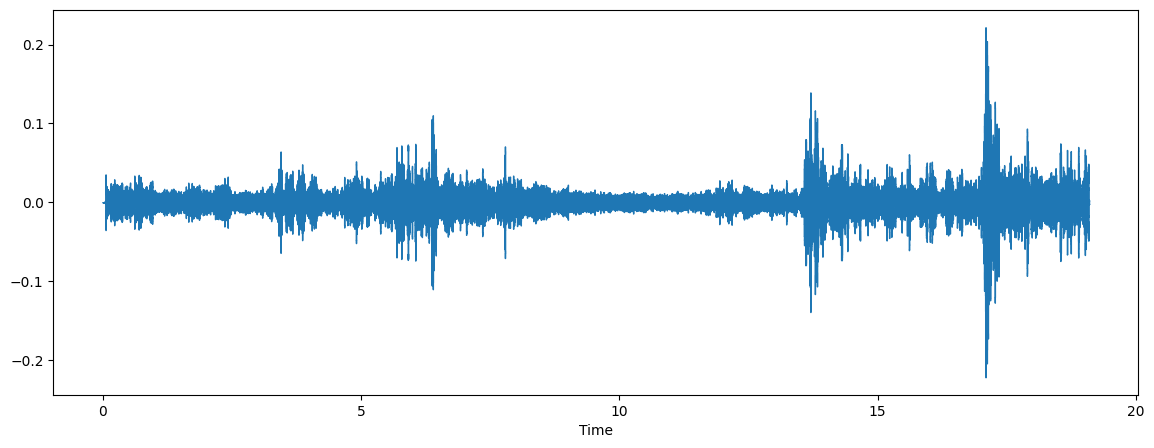

In [6]:
## Loading the sample audio files from two different species and also visualizing the waves
plt.figure(figsize=(14,5))
data,sample_rate=librosa.load(filename)
librosa.display.waveshow(data,sr=sample_rate)
ipd.Audio(filename)

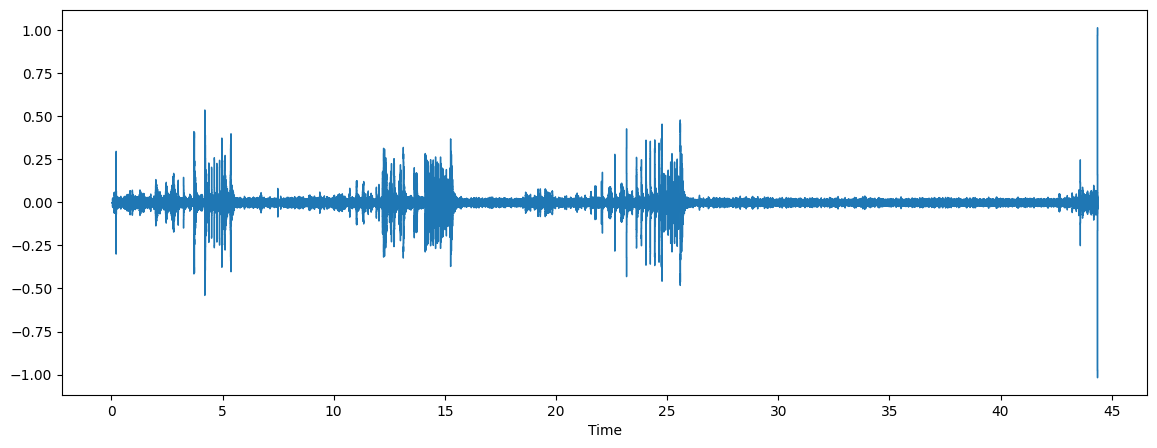

In [7]:
plt.figure(figsize=(14,5))
data_audio,sample_rate=librosa.load(filename1)
librosa.display.waveshow(data_audio,sr=sample_rate)
ipd.Audio(filename1)

In [8]:
metadata=pd.read_csv("/kaggle/input/birdclef-2023/train_metadata.csv")
metadata.head()

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename
0,abethr1,[],['song'],4.3906,38.2788,Turdus tephronotus,African Bare-eyed Thrush,Rolf A. de By,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/128013,abethr1/XC128013.ogg
1,abethr1,[],['call'],-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,3.5,https://www.xeno-canto.org/363501,abethr1/XC363501.ogg
2,abethr1,[],['song'],-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,3.5,https://www.xeno-canto.org/363502,abethr1/XC363502.ogg
3,abethr1,[],['song'],-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://www.xeno-canto.org/363503,abethr1/XC363503.ogg
4,abethr1,[],"['call', 'song']",-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,4.5,https://www.xeno-canto.org/363504,abethr1/XC363504.ogg


In [9]:
## There are null values in the dataset and hence dropping the null values
metadata.isnull().sum()

primary_label         0
secondary_labels      0
type                  0
latitude            227
longitude           227
scientific_name       0
common_name           0
author                0
license               0
rating                0
url                   0
filename              0
dtype: int64

In [10]:
metadata=metadata.dropna()

In [11]:
## There are no missing values
metadata.isnull().sum()

primary_label       0
secondary_labels    0
type                0
latitude            0
longitude           0
scientific_name     0
common_name         0
author              0
license             0
rating              0
url                 0
filename            0
dtype: int64

In [12]:
## There are 16714 rows and 12 columns after removing the null values from Latitude and Longitude
metadata.shape

(16714, 12)

### Match the model's output with the bird species in the competition

The competition includes 264 classes of birds, 261 of which exist in this model. We'll set up a way to map the model's output logits to our competition.

In [13]:
model = hub.load('https://kaggle.com/models/google/bird-vocalization-classifier/frameworks/tensorFlow2/variations/bird-vocalization-classifier/versions/2')
labels_path = hub.resolve('https://kaggle.com/models/google/bird-vocalization-classifier/frameworks/tensorFlow2/variations/bird-vocalization-classifier/versions/2') + "/assets/label.csv"

In [14]:
## Find the name of the class with the top score when mean-aggregated across frames.
def class_names_from_csv(class_map_csv_text):
    """Returns list of class names corresponding to score vector."""
    with open(labels_path) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        class_names = [mid for mid, desc in csv_reader]
        return class_names[1:]

## note that the bird classifier classifies a much larger set of birds than the
## competition, so we need to load the model's set of class names or else our 
## indices will be off.
classes = class_names_from_csv(labels_path)

In [15]:
train_metadata = pd.read_csv("/kaggle/input/birdclef-2023/train_metadata.csv")
train_metadata.head()
competition_classes = sorted(train_metadata.primary_label.unique())

forced_defaults = 0
competition_class_map = []
for c in competition_classes:
    try:
        i = classes.index(c)
        competition_class_map.append(i)
    except:
        competition_class_map.append(0)
        forced_defaults += 1
        
## this is the count of classes not supported by our pretrained model
## you could choose to simply not predict these, set a default as above,
## or create your own model using the pretrained model as a base.
forced_defaults

3

### Data Preprocessing

The following functions are one way to load the audio provided and break it up into the five-second samples with a sample rate of 32,000 required by the competition.

In [16]:
def frame_audio(
      audio_array: np.ndarray,
      window_size_s: float = 5.0,
      hop_size_s: float = 5.0,
      sample_rate = 32000,
      ) -> np.ndarray:
    
    """Helper function for framing audio for inference."""
    """ using tf.signal """
    if window_size_s is None or window_size_s < 0:
        return audio_array[np.newaxis, :]
    frame_length = int(window_size_s * sample_rate)
    hop_length = int(hop_size_s * sample_rate)
    framed_audio = tf.signal.frame(audio_array, frame_length, hop_length, pad_end=True)
    return framed_audio

def ensure_sample_rate(waveform, original_sample_rate,
                       desired_sample_rate=32000):
    """Resample waveform if required."""
    if original_sample_rate != desired_sample_rate:
        waveform = tfio.audio.resample(waveform, original_sample_rate, desired_sample_rate)
    return desired_sample_rate, waveform

In [17]:
## Below we load one training sample - use the Audio function to listen to the samples inside the notebook!
audio, sample_rate = librosa.load("/kaggle/input/birdclef-2023/train_audio/afghor1/XC156639.ogg")
sample_rate, wav_data = ensure_sample_rate(audio, sample_rate)

## Make Predictions
Each test sample is cut into 5-second chunks. We use the pretrained model to return probabilities for all 10k birds included in the model, then pull out the classes used in this competition to create a final submission row. Note that we are NOT doing anything special to handle the 3 missing classes; those will need fine-tuning / transfer learning, which will be handled in a separate notebook.

In [18]:
fixed_tm = frame_audio(wav_data)
logits, embeddings = model.infer_tf(fixed_tm[:1])
probabilities = tf.nn.softmax(logits)
argmax = np.argmax(probabilities)
print(f"The audio is from the class {classes[argmax]} (element:{argmax} in the label.csv file), with probability of {probabilities[0][argmax]}")

The audio is from the class afghor1 (element:46 in the label.csv file), with probability of 0.6791707873344421


In [19]:
def predict_for_sample(filename, sample_submission, frame_limit_secs=None):
    file_id = filename.split(".ogg")[0].split("/")[-1]
    
    audio, sample_rate = librosa.load(filename)
    sample_rate, wav_data = ensure_sample_rate(audio, sample_rate)
    
    fixed_tm = frame_audio(wav_data)
    
    frame = 5
    all_logits, all_embeddings = model.infer_tf(fixed_tm[:1])
    for window in fixed_tm[1:]:
        if frame_limit_secs and frame > frame_limit_secs:
            continue
        
        logits, embeddings = model.infer_tf(window[np.newaxis, :])
        all_logits = np.concatenate([all_logits, logits], axis=0)
        frame += 5
    
    frame = 5
    all_probabilities = []
    for frame_logits in all_logits:
        probabilities = tf.nn.softmax(frame_logits).numpy()
        
        ## set the appropriate row in the sample submission
        sample_submission.loc[sample_submission.row_id == file_id + "_" + str(frame), competition_classes] = probabilities[competition_class_map]
        frame += 5

## Generate a Submission

 All of the test samples as discussed above will be processed, creating output rows, and saving them in the provided sample_submission.csv. Finally, we save these rows to our final output file: submission.csv. This is the file that gets submitted and scored when we will submit the notebook

In [20]:
test_samples = list(glob.glob("/kaggle/input/birdclef-2023/test_soundscapes/*.ogg"))
test_samples

['/kaggle/input/birdclef-2023/test_soundscapes/soundscape_29201.ogg']

In [21]:
sample_sub = pd.read_csv("/kaggle/input/birdclef-2023/sample_submission.csv")
sample_sub[competition_classes] = sample_sub[competition_classes].astype(np.float32)
sample_sub.head()

,row_id,abethr1,abhori1,abythr1,afbfly1,afdfly1,afecuc1,affeag1,afgfly1,afghor1,...,yebsto1,yeccan1,yefcan,yelbis1,yenspu1,yertin1,yesbar1,yespet1,yetgre1,yewgre1
0,soundscape_29201_5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,soundscape_29201_10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,soundscape_29201_15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
frame_limit_secs = 15 if sample_sub.shape[0] == 3 else None
for sample_filename in test_samples:
    predict_for_sample(sample_filename, sample_sub, frame_limit_secs=15)

In [23]:
sample_sub

,row_id,abethr1,abhori1,abythr1,afbfly1,afdfly1,afecuc1,affeag1,afgfly1,afghor1,...,yebsto1,yeccan1,yefcan,yelbis1,yenspu1,yertin1,yesbar1,yespet1,yetgre1,yewgre1
0,soundscape_29201_5,7.403938e-07,8.661650e-08,9.372014e-07,2.236589e-08,5.289250e-08,3.728552e-07,0.000002,1.200610e-07,0.000002,...,7.781559e-09,1.445370e-07,2.546039e-07,4.357360e-07,1.041987e-08,8.872025e-07,2.541765e-08,2.122487e-10,5.569804e-08,3.915079e-07
1,soundscape_29201_10,1.421195e-07,2.047875e-05,1.361772e-08,2.826324e-06,8.974560e-07,2.377770e-05,0.000028,3.008759e-06,0.000012,...,3.595806e-08,1.105986e-06,8.611138e-06,7.898570e-05,1.942171e-06,1.658372e-05,4.993752e-07,3.286013e-07,3.167425e-06,1.432528e-05
2,soundscape_29201_15,4.951651e-05,1.117501e-05,8.751177e-06,1.051048e-06,6.304856e-07,1.165694e-04,0.000002,4.099561e-06,0.000011,...,2.168676e-07,8.455005e-06,7.301624e-06,7.492738e-05,1.087548e-06,2.005890e-05,9.687158e-08,1.176704e-04,1.620371e-06,1.415169e-05


In [24]:
sample_sub.to_csv("submission.csv", index=False)